# Generating Euclidean TSP using NetworkX

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Custom imports
from qaoa_vrp.generators.random_instances import generate_euclidean_graph
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph

%matplotlib notebook
sns.set()

## Undirected Graphs

In [2]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(0,4),(2,0)])

<IPython.core.display.Javascript object>


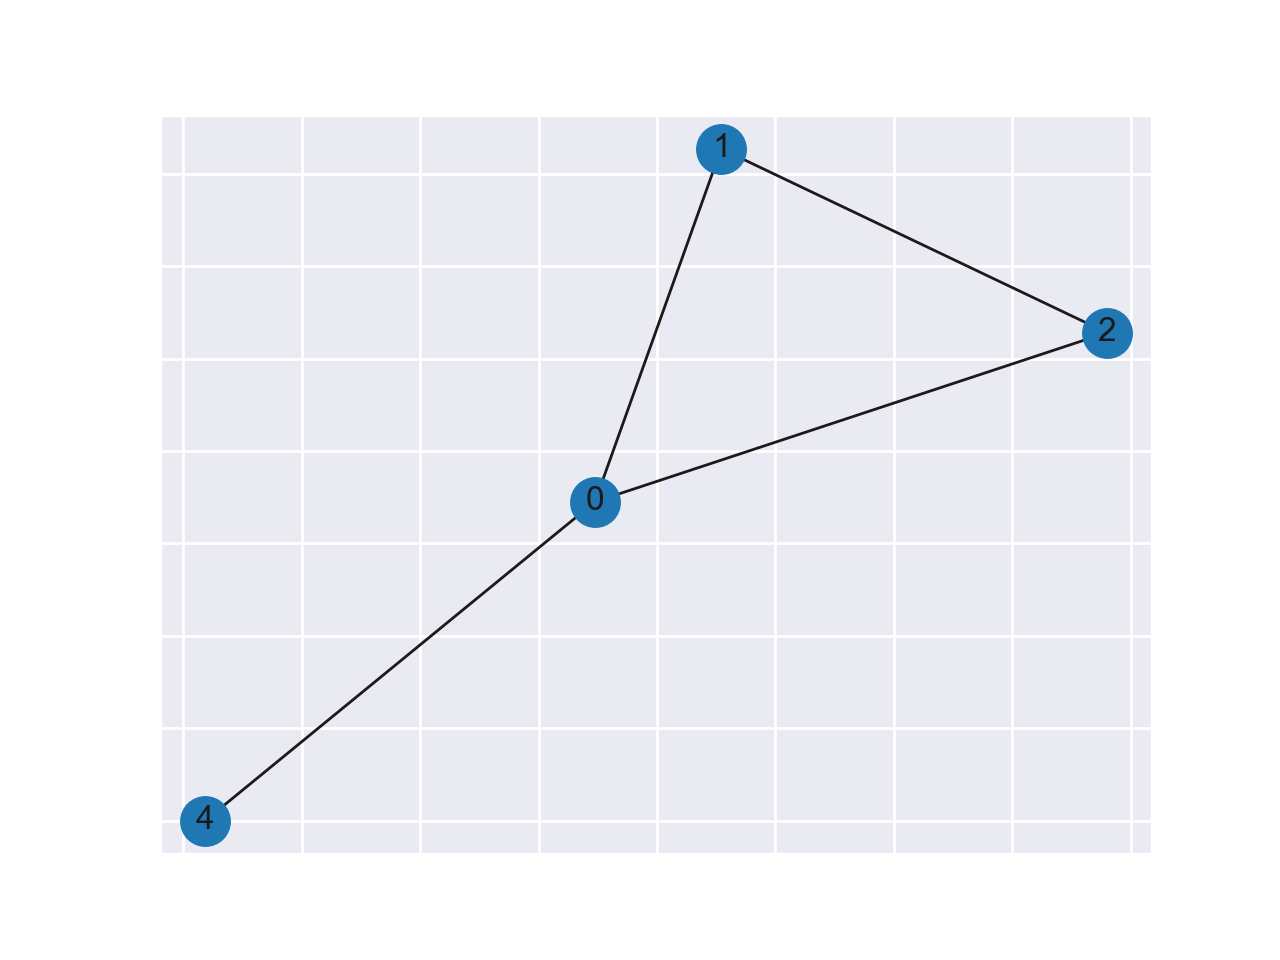

In [3]:
plt.figure()
nx.draw_networkx(G)

## Directed Graph

In [4]:
G1 = nx.DiGraph()
G1.add_edge(1,2)
G1.add_edge(1,3)

<IPython.core.display.Javascript object>


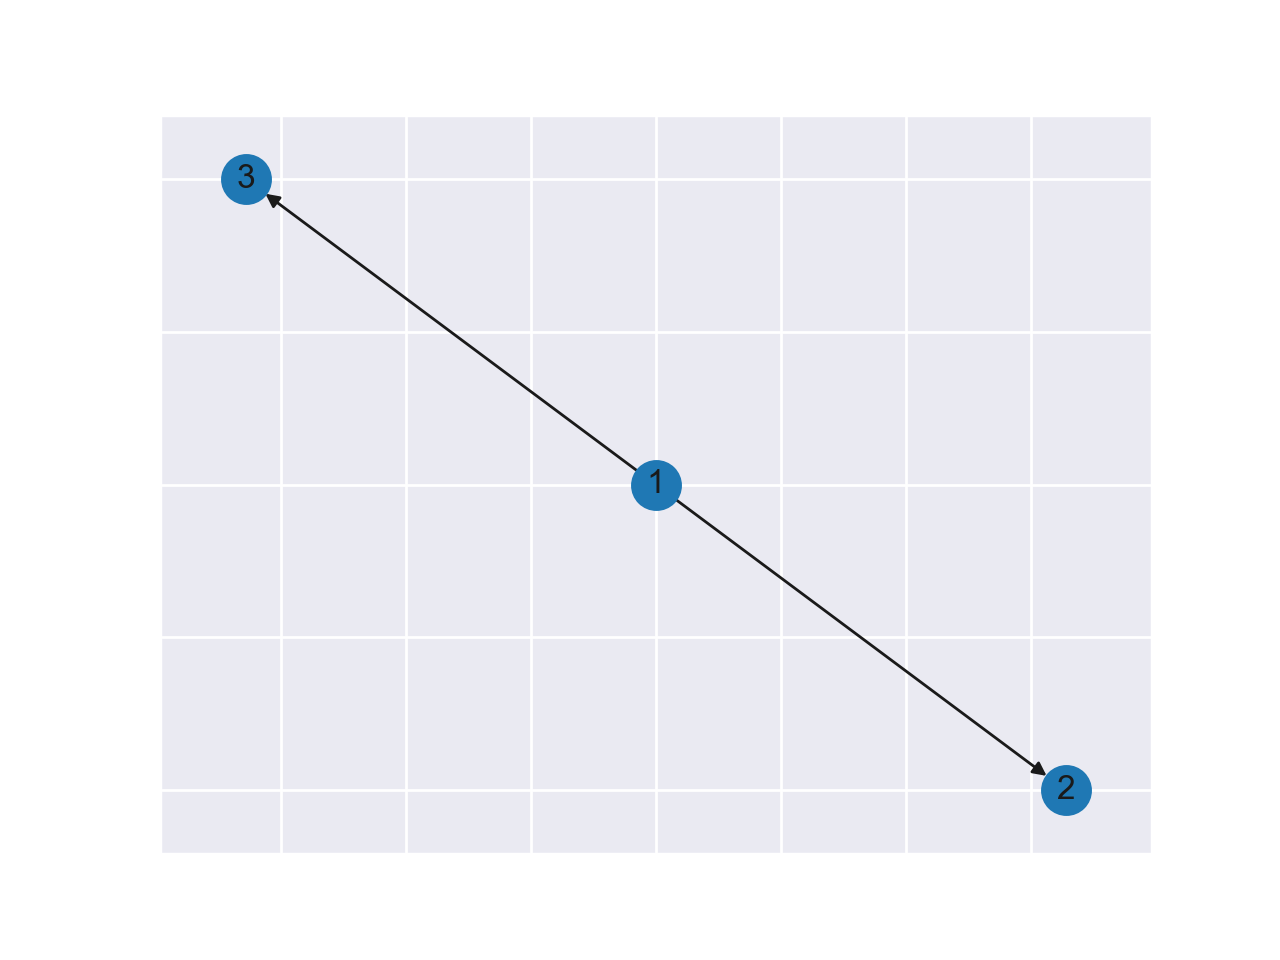

In [5]:
plt.figure()
nx.draw_networkx(G1)

# Weighted Graph

In [6]:
G_weighted = nx.Graph()

# Add a node to a specific position
G.add_node(0, pos = (1,1))
G.add_node(1, pos = (1,2))
G.add_node(2, pos = (2,4))
G.add_node(4, pos = (3,4))

# Add edges with costs
G.add_edge(0,1, weight=20, relation='friend')
G.add_edge(1,2, weight=30, relation='enemy')
G.add_edge(0,2, weight=10, relation='enemy')
G.add_edge(0,4, weight=100, relation='friend')

# Extract weights and positions
weights = nx.get_edge_attributes(G, 'weight')
pos = nx.get_node_attributes(G, 'pos')
relation = nx.get_edge_attributes(G, 'relation')

# Key

<IPython.core.display.Javascript object>


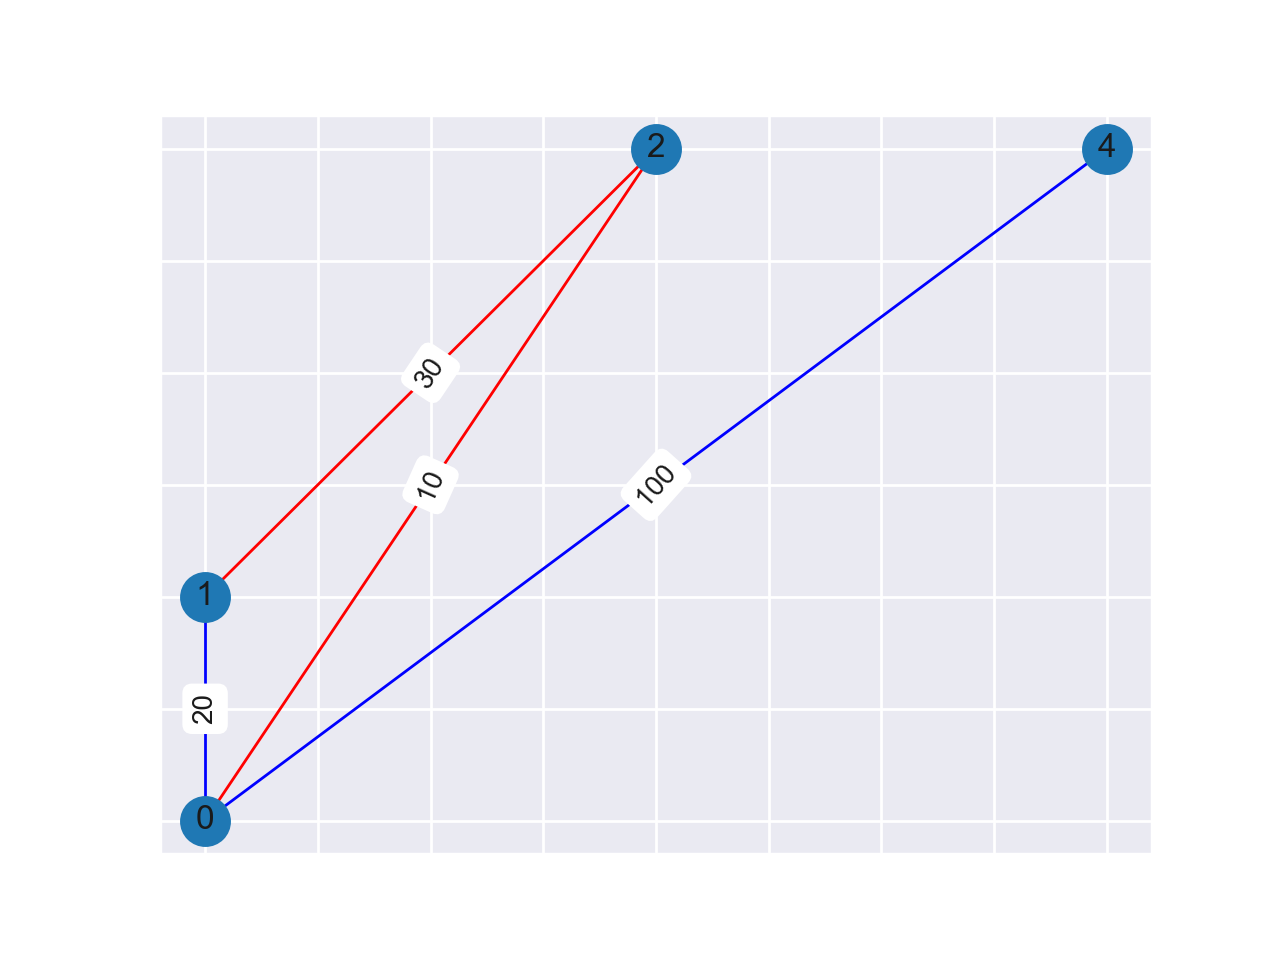

In [7]:
plt.figure()
dic = {'enemy':'red', 'friend':'blue'}
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
nx.draw_networkx(G,pos, edge_color=[dic[x] for x in relation.values()])

## Euclidean TSP Instance

1. Make a distance function that takes in two points $(x_0, y_0)$ and $(x_1, y_1)$
2. Initialise an empty graph
3. Randomly generate positions on a 2D plane and allocate these points as nodes
4. Create a complete graph by connecting all edges together and make the cost the euclidean distance between the two points

In [8]:
# Function to construct euclidean distances
def distance(i, j):
    """ Function to compute distances"""
    if isinstance(i, tuple) and isinstance(j, tuple):
        dx = j[0] - i[0]
        dy = j[1] - i[1]
        return math.sqrt(dx*dx + dy*dy)
    else:
        raise TypeError('Incorrect Type - Please feed a tuple of coordinates')

Algorithm to produce the network

In [9]:
# Number of cities
n = 4
V=range(n)

# Initialise empty graph
G = nx.Graph()

# Build nodes
nodes = [(i,{'pos':tuple(np.random.random(2))}) for i in V]
G.add_nodes_from(nodes)

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Add edges
for i in V:
    for j in V:
        if i != j:
            G.add_edge(i, j, cost=distance(pos[i],pos[j]))

Build a network according to `networkx`

<IPython.core.display.Javascript object>


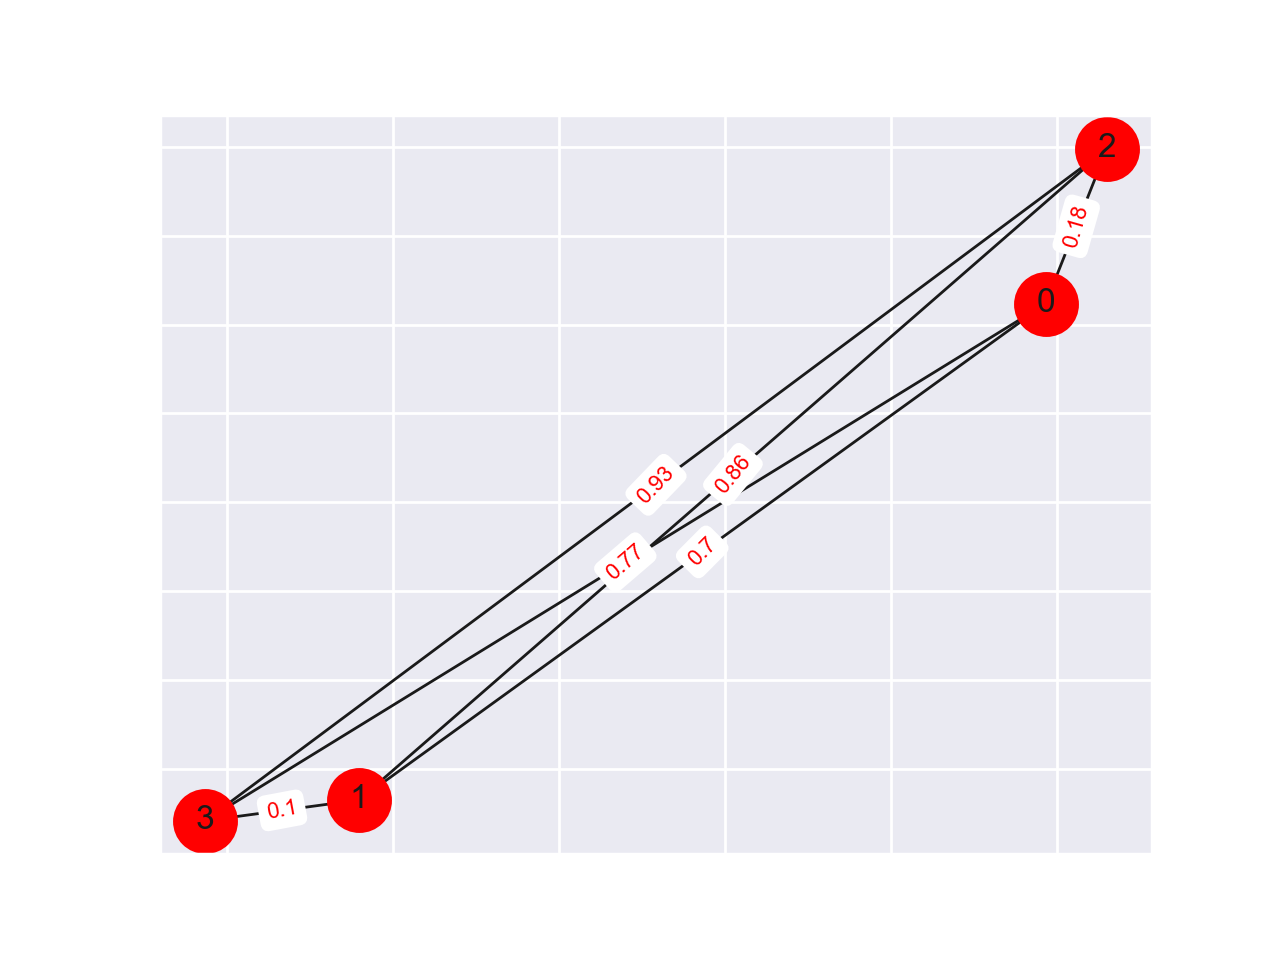

In [10]:
# Draw network
plt.figure()
# Extract costs
costs = nx.get_edge_attributes(G, 'cost')

# If you want to add edgelabels
for edge in G.edges():
    # Create a new attribute in the edge
    G[edge[0]][edge[1]]['cost_label'] = np.round(G[edge[0]][edge[1]]['cost'],2)

cost_labels = nx.get_edge_attributes(G, 'cost_label')

# Draw the edge labels on the graph
nx.draw_networkx_edge_labels(
    G, 
    pos, 
    edge_labels=cost_labels, 
    font_size=8,
    font_color='red'
)

# Draw the graph
nx.draw_networkx(
    G, 
    pos,
    node_color='red',
    node_size=500
)

Great! Now I have wrapped this up in a function called `generate_euclidean_graph`. Which we can import and use out of the box

In [11]:
G = generate_euclidean_graph(100)

<IPython.core.display.Javascript object>


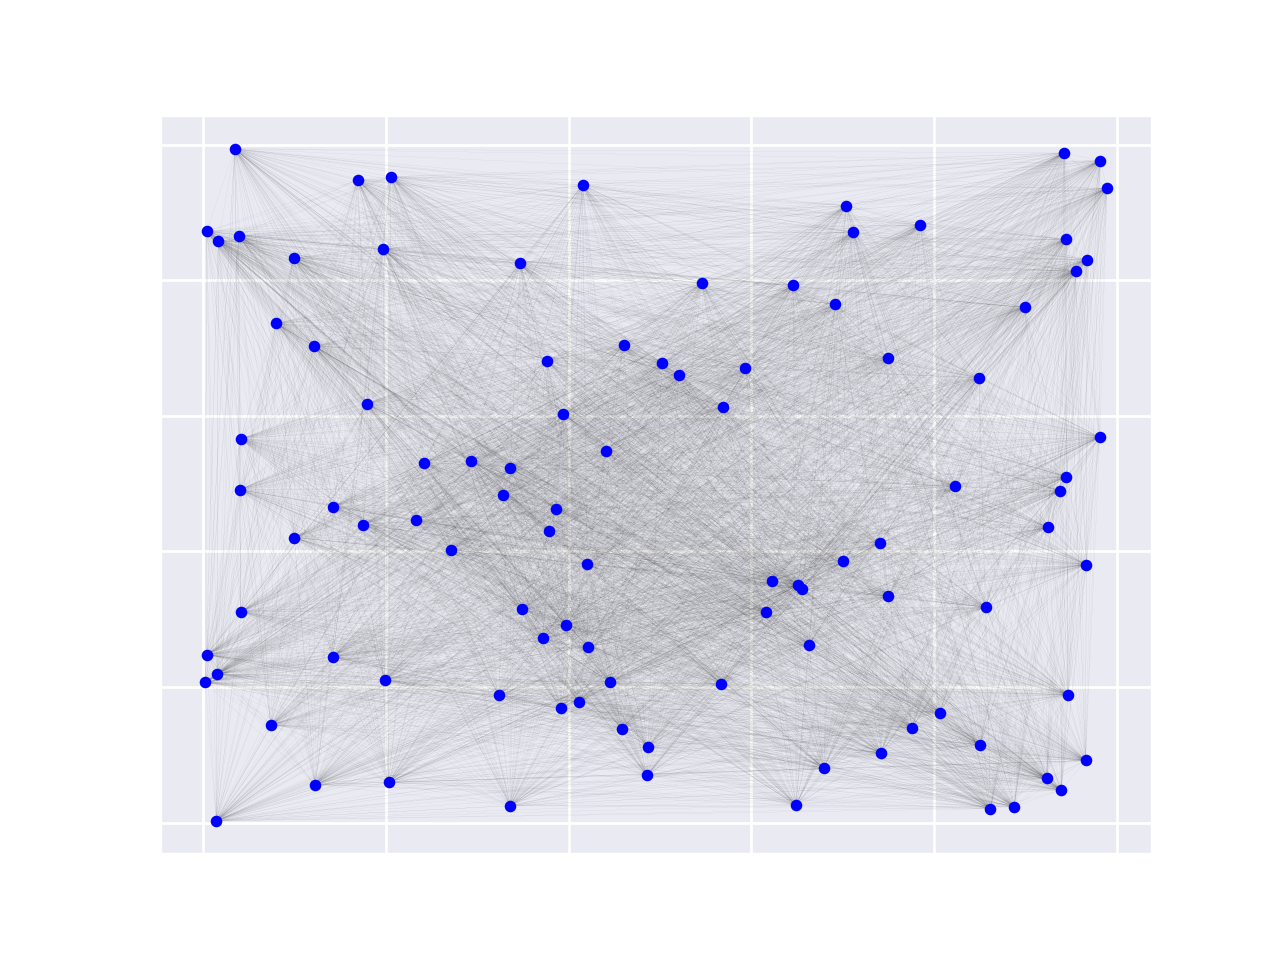

In [12]:
draw_euclidean_graph(G,node_color='blue',width=0.01,node_size=10)

## Euclidean Graphs with Outliers

We want to see the effect of changing the structure of our TSPs. One way we can achieve this is by creating TSPs with outlier structure. For example having a network where a certain % of nodes are close to each other and the remaining nodes are further away.

To do this lets start off by generating a vanilla euclidean TSP instance. Then we can randomly pick $k$ nodes and then move those $k$ nodes away in the cartesian plane.

Let's start off by generating a vanilla euclidean TSP with four nodes.

In [13]:
G = generate_euclidean_graph(4)

Great, let's visualise this

<IPython.core.display.Javascript object>


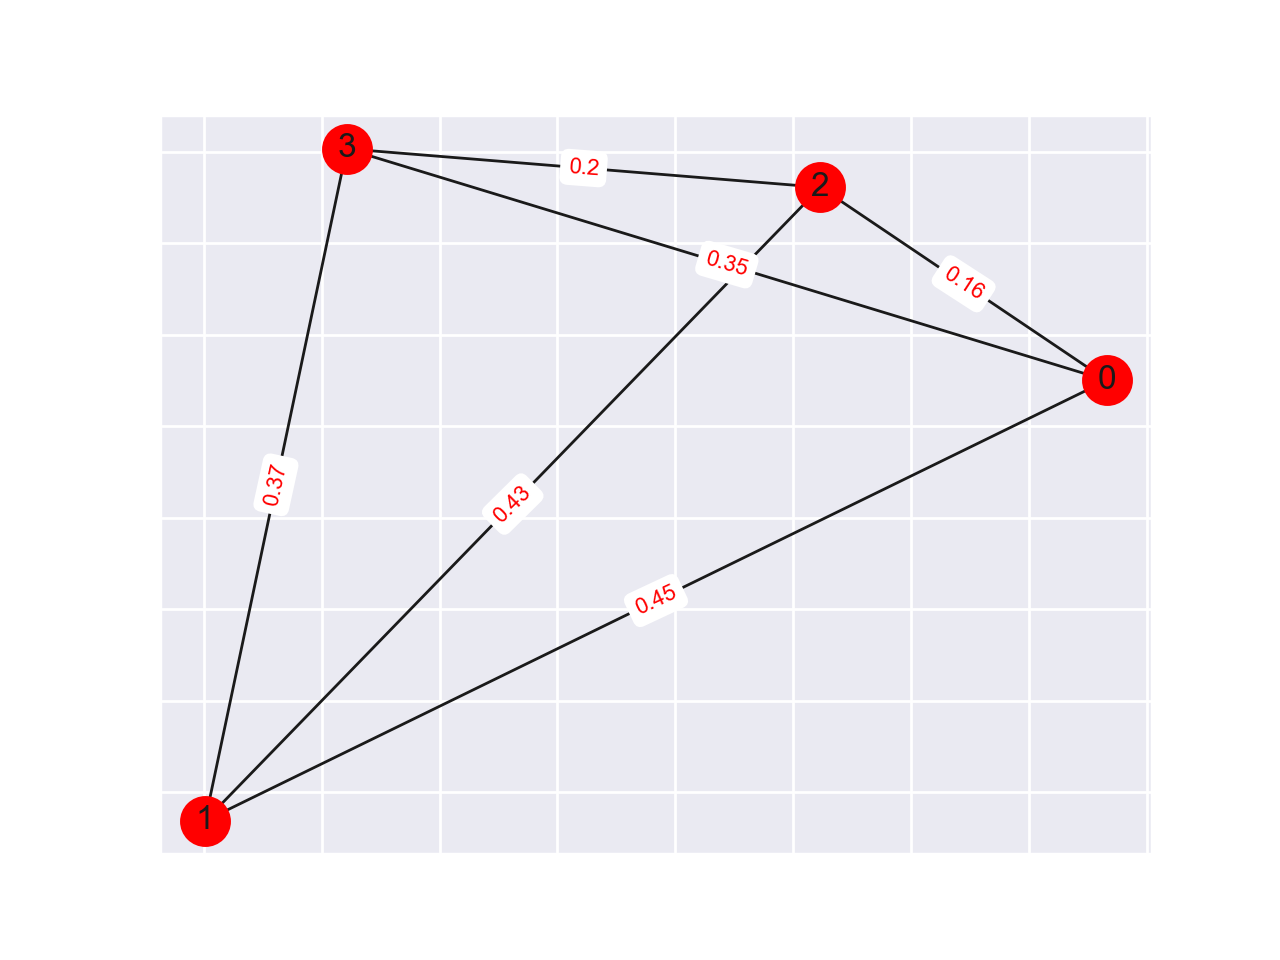

In [14]:
draw_euclidean_graph(G, draw_edge=True, with_label=True)

Each of the nodes above have generated so the exist in the unit square. This means the position $\vec{x}=(x_i, y_i)$ for each node is $\{\vec{x}:\vec{x} \in \mathbb{R}^2 \land x_i,y_i \in [0,1]\}$. This bounds the maximum distance any node could ever by away from one node to be $\sqrt{2}$.

To construct an instance with an outlier, lets move a specific node either up or down and left or right by $\gamma\sqrt{2}$. Where $\gamma \geq 2$

In [15]:
def get_direction():
    direction = np.random.randint(-1, 2) 
    if direction == 0:
        return get_direction()
    else:
        return direction

In [16]:
# Lets first pick k
k = 1
gamma = 2
# Randomly select k nodes from the network (check k < N)
if k > G.number_of_nodes():
    raise ValueError("k=%s cannot be higher than the number of nodes N=%s"%(k, G.number_of_nodes()))
else:
    # Ensure we get k distinct nodes being selected
    random_nodes = np.random.choice(range(G.number_of_nodes()),k,replace=False)

In [17]:
nodes_to_move = [nx.nodes(G)[i] for i in random_nodes]

In [18]:
# Update the node locations
for node in random_nodes:
    # Extract node position
    node_pos = G.nodes()[node]['pos']
    # Move node
    x_move_direction = get_direction()
    y_move_direction = get_direction()
    x_new = G.nodes()[node]['pos'][0] + x_move_direction*gamma*np.sqrt(2)
    y_new = G.nodes()[node]['pos'][1] + y_move_direction*gamma*np.sqrt(2)
    G.nodes()[node]['pos'] = (x_new, y_new)

In [19]:
# Get new position data
pos = nx.get_node_attributes(G, 'pos')

# Recalculate edge distances
for i in V:
    for j in V:
        if i != j:
            G.add_edge(i, j, cost=distance(pos[i],pos[j]))

<IPython.core.display.Javascript object>


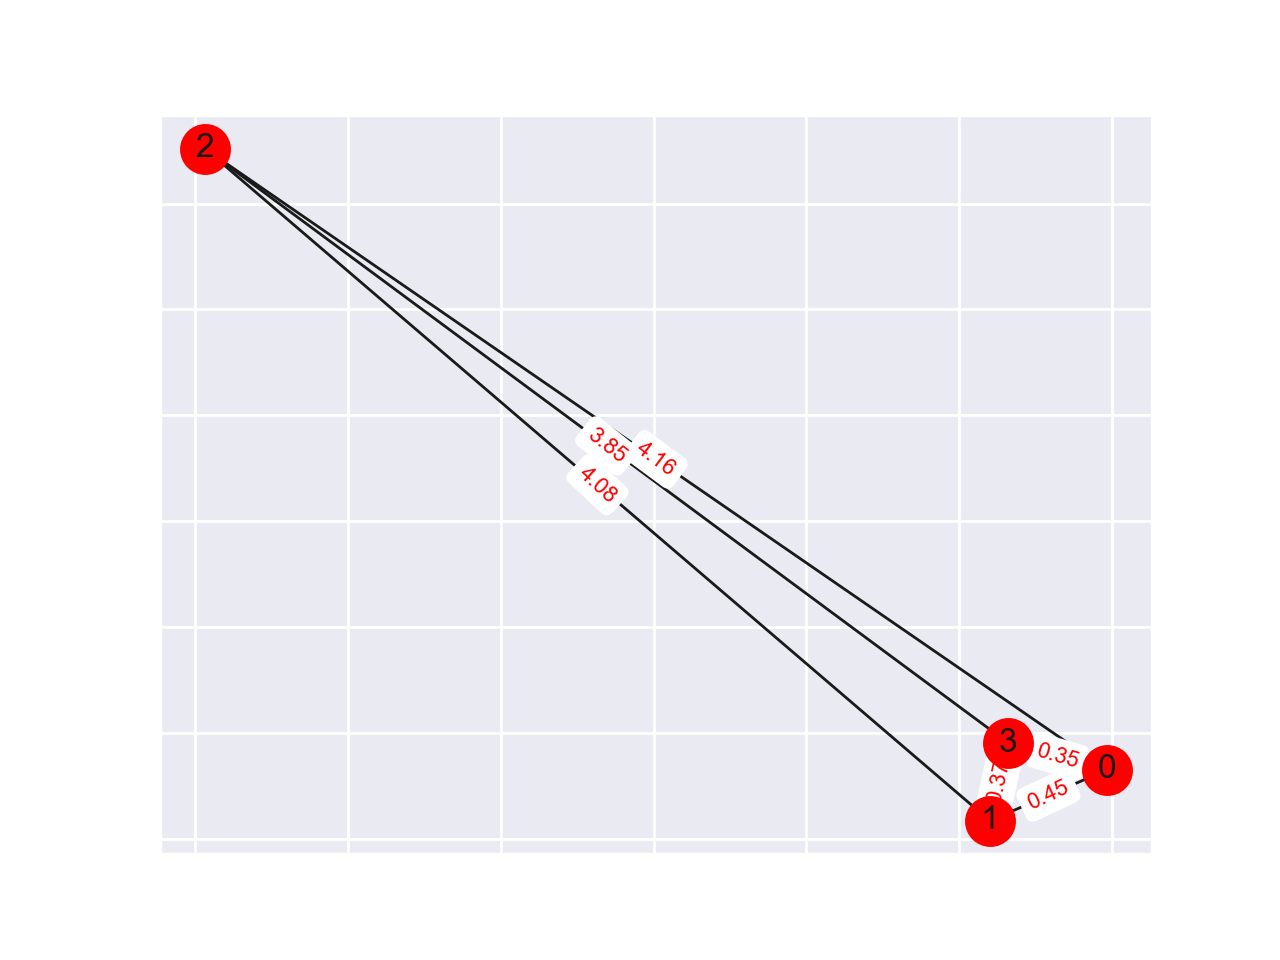

In [20]:
draw_euclidean_graph(G, draw_edge=True, with_label=True)